In [1]:
import numpy as np
import numpy.linalg as lin
from scipy.linalg import expm
import numpy.random as npr  
import random
from time import time
# import scipy.stats as si
# import scipy.optimize as sco
from scipy import interpolate 
from scipy.linalg import expm
from scipy.fftpack import fft, ifft
from scipy.fftpack import fft2, ifft2
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'

## Monte Carlo Simulation

In [46]:
S0, G, l1, l2, r1, r2, sigma1, sigma2 = 100, 100, 0.4, 0.3, 0.05, 0.02, 0.15, 0.4
Maturities = [15, 15, 15, 15, 15, 15]
I = 100000
Ini_State = 1.0
Ave = []
for j in range(6):
    T = Maturities[j]
    SumofTermVals = 0.0
    TermValOneRun = 0.0
    for i in range(I):
        LogStock = float(np.log(S0))
        Cur_Time = 0.0
        Cur_State = Ini_State
        tau1 = 0.0
        while Cur_Time < T: # Pr(tau_i > t) = exp(-lambda_i * t)
            p = random.uniform(0, 1)
            if Cur_State == 1:
                ExpRV = -1 * np.log(p) / l1
            else:
                ExpRV = -1 * np.log(p) / l2
            if Cur_Time + ExpRV < T and Cur_State == 1:
                tau1 = tau1 + ExpRV
            else:
                if Cur_State == 1:
                    tau1 = tau1 + T - Cur_Time
            Cur_Time = Cur_Time + ExpRV
            if Cur_State == 1:
                Cur_State = 2
            else:
                Cur_State = 1
        SimRand = float(np.random.standard_normal())
        LogStock = LogStock + (r1 - 0.5 * sigma1**2) * tau1 + \
                    (r2 - 0.5 * sigma2**2) * (T-tau1) \
                    + SimRand*np.sqrt(tau1*sigma1**2 \
                    + (T-tau1)*sigma2**2)
        TermValOneRun = np.maximum(0, np.exp(LogStock) - G)
        SumofTermVals = SumofTermVals + TermValOneRun
    callprice = (SumofTermVals / I) * np.exp(-1 * ((tau1 * r1) + r2 * (T - tau1)))
    Ave.append(callprice)
    print('%.1f %2.10f' % (T, callprice))
print('Mean:%2.10f' % (np.mean(Ave))) # 58.728677343835564

15.0 58.3830984785
15.0 67.7498818515
15.0 60.3906803405
15.0 64.5492512498
15.0 53.8316069757
15.0 60.9323484709
Mean:60.9728112278


## Parameters

In [3]:
S0, G, T, m, me, N, X = 100.0, 100.0, 15, 0.01, 0.0058, 2048, 7

r = [0.05, 0.02]
drift = [0.1, 0.04]
sigma = [0.15, 0.4]

A = np.array([[-0.4, 0.4], 
              [0.3, -0.3]])

Pi0 = np.array([[0.9999], 
                [0.0001]])

## Zero-coupon Bond

In [4]:
def z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z = np.exp(-r2 * T) * Pi.T.dot(E.dot(One))
    return Z[0, 0]

Z15 = z(r, T, A, Pi0)
Z15 # 0.5985563466210917

0.5985563466210917

## Zero-coupon Bond' Rho1

In [5]:
def rho1_z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z = -np.exp(-r2 * T) * Pi.T.dot(T * D.dot(E.dot(One))) / 100 # 1% change
    return Z[0, 0]

Rho1_Z = rho1_z(r, T, A, Pi0)
Rho1_Z # -0.08977408189153178

-0.08977408189153178

## Zero-coupon Bond' Rho2

In [6]:
def rho2_z(r, T, A, Pi):
    r1, r2 = r[0], r[1]
    dr = r1 - r2
    D = np.array([[1, 0], [0, 0]])
    E = expm((A - dr * D) * T)
    One = np.ones((2, 1))
    Z1 = np.exp(-r2 * T) * Pi.T.dot(T * D.dot(E.dot(One)))
    Z2 = -T * np.exp(-r2 * T) * Pi.T.dot(E.dot(One))
    Z = (Z1 + Z2) / 100 # 1% change
    return Z[0, 0]

Rho2_Z = rho2_z(r, T, A, Pi0)
Rho2_Z # -9.370101631969164e-06

-9.370101631969164e-06

In [7]:
s1, s5, s10 = 0.995, 0.99,0.97 
s13, s14, s15, s16 = 0.9517656379011263, 0.9460557176086264, 0.9389258056865387, 0.9320145341177468
S = [0, s1, 0, 0, 0, s5, 0, 0, 0, 0, s10, 0, 0, s13, s14, s15, s16]

## Price

In [8]:
def rsln_gmmbprice_fst(S0, G, T, r, sigma, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_c = np.maximum(ST - G, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    c1 = ifft((char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_c)).real
    c2 = ifft((char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_c)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, c1)
    f2 = interpolate.PchipInterpolator(ST, c2)
    C = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    Price = S[T] * (G * Z15 + C)
    return Price[0, 0]

rsln_gmmbprice_fst(S0, G, T, r, sigma, A, Pi0, N, X) # (58.728677343835564, 111.34187069196554)

(58.728677343835564, 111.34187069196554)

## Delta

In [20]:
def rsln_gmmbdelta_fst(S0, G, T, r, sigma, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_c = np.maximum(ST - G, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    delta1_c = (ifft(1j * w * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_c)) / (ST)).real
    delta2_c = (ifft(1j * w * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_c)) / (ST)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, delta1_c)
    f2 = interpolate.PchipInterpolator(ST, delta2_c)
    Delta_C = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    Delta = S[T] * Delta_C
    return Delta[0, 0]

rsln_gmmbdelta_fst(S0, G, T, r, sigma, A, Pi0, N, X) # 0.7994567699863706

0.7994567699863706

## Gamma

In [24]:
def rsln_gmmbgamma_fst(S0, G, T, r, sigma, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx # 1/(2*dx)
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_c = np.maximum(ST - G, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method
    gamma1_c = (ifft(-(1j * w + w ** 2) * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_c)) / (ST ** 2)).real
    gamma2_c = (ifft(-(1j * w + w ** 2) * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_c)) / (ST ** 2)).real
    # Interpolate prices
    f1 = interpolate.PchipInterpolator(ST, gamma1_c)
    f2 = interpolate.PchipInterpolator(ST, gamma2_c)
    Gamma_C = Pi.T.dot(np.array([[f1(S0)], [f2(S0)]]))
    Gamma = S[T] * Gamma_C
    return Gamma[0, 0]

rsln_gmmbgamma_fst(S0, G, T, r, sigma, A, Pi0, N, X) # 0.0019242244428033604

0.0019242244428033604

## Vega

In [27]:
def rsln_gmmbvega_fst(S0, G, T, r, sigma, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx # 1/(2*dx)
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_c = np.maximum(ST - G, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for sigma1
    vega11_c = ifft(-(1j * w + w ** 2) * sigma1 * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_c)).real
    vega12_c = ifft(0 * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_c)).real
    # Interpolate prices
    f11 = interpolate.PchipInterpolator(ST, vega11_c)
    f12 = interpolate.PchipInterpolator(ST, vega12_c)
    Vega1_C = Pi.T.dot(np.array([[f11(S0)], [f12(S0)]])) / 100
    Vega1 = S[T] * Vega1_C
    # FST method for sigma2
    vega21_c = ifft(0 * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_c)).real
    vega22_c = ifft(-(1j * w + w ** 2) * sigma2 * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_c)).real
    # Interpolate prices
    f21 = interpolate.PchipInterpolator(ST, vega21_c)
    f22 = interpolate.PchipInterpolator(ST, vega22_c)
    Vega2_C = Pi.T.dot(np.array([[f21(S0)], [f22(S0)]])) / 100
    Vega2 = S[T] * Vega2_C

    return (Vega1[0, 0], Vega2[0, 0])

rsln_gmmbvega_fst(S0, G, T, r, sigma, A, Pi0, N, X) # (0.4329064462048502, 0.00011747702236644839)

(0.4329064462048502, 0.00011747702236644839)

## Rho

In [40]:
def rsln_gmmbrho_fst(S0, G, T, r, sigma, A, Pi, N, X):
    # parameter
    r1, r2 = r[0], r[1]
    sigma1, sigma2 = sigma[0], sigma[1]
    A11, A12, A21, A22 = A[0, 0], A[0, 1], A[1, 0], A[1, 1]
    # Real space
    x_min, x_max = -X, X
    dx = (x_max - x_min) / (N - 1)
    x = np.linspace(x_min, x_max, N)
    # Fourier space
    epsilon = 0.0001
    w_max = np.pi / dx # 1/(2*dx)
    dw = 2 * w_max / N
    w = np.hstack((np.arange(0, w_max + epsilon, dw), np.arange(-w_max + dw, -dw + epsilon, dw)))
    # Payoff function at time T
    ST = S0 * np.exp(x)
    payoff_c = np.maximum(ST - G, 0)
    # Matrix characteristic funciton
    psi1 = 1j * (r1 - 0.5 * sigma1 ** 2) * w - 0.5 * (sigma1 * w) ** 2 - r1
    psi2 = 1j * (r2 - 0.5 * sigma2 ** 2) * w - 0.5 * (sigma2 * w) ** 2 - r2
    Psi = np.zeros((N, 2, 2), dtype=complex)
    for i in range(N):
        Psi[i, 0] = [A11 + psi1[i], A12]
        Psi[i, 1] = [A21, A22 + psi2[i]]
    char = np.array([expm(i * T) for i in Psi])
    # FST method for sigma1
    rho11_c = ifft((1j * w - 1) * T * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_c)).real
    rho12_c = ifft(0 * (char[:, 0, 0] + char[:, 0, 1]) * fft(payoff_c)).real
    # Interpolate prices
    f11 = interpolate.PchipInterpolator(ST, rho11_c)
    f12 = interpolate.PchipInterpolator(ST, rho12_c)
    Rho1_C = Pi.T.dot(np.array([[f11(S0)], [f12(S0)]])) / 100
    Rho1 = S[T] * (Rho1_C + G * rho1_z(r, T, A, Pi))
    rho2_z(r, T, A, Pi0)
    # FST method for sigma2
    rho21_c = ifft(0 * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_c)).real
    rho22_c = ifft((1j * w - 1) * T * (char[:, 1, 0] + char[:, 1, 1]) * fft(payoff_c)).real
    # Interpolate prices
    f21 = interpolate.PchipInterpolator(ST, rho21_c)
    f22 = interpolate.PchipInterpolator(ST, rho22_c)
    Rho2_C = Pi.T.dot(np.array([[f21(S0)], [f22(S0)]])) / 100
    Rho2 = S[T] * (Rho2_C + G * rho2_z(r, T, A, Pi))

    return (Rho1[0, 0], Rho2[0, 0])

rsln_gmmbrho_fst(S0, G, T, r, sigma, A, Pi0, N, X)

(-4.708894984141848, -0.0005340699342956186)

In [39]:
r[0]

0.05

In [ ]:
(-839.1917964649222, -0.08763258915349346)

## Plots

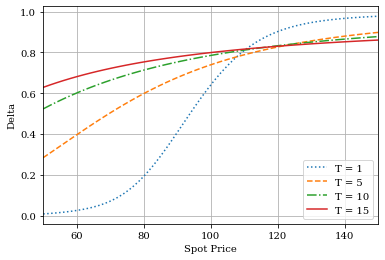

In [23]:
spot = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in spot:
        temp = rsln_gmmbdelta_fst(i, G, time[j], r, sigma, A, Pi0, N, X)
        v.append(temp)
    plt.plot(spot, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Spot Price')
plt.xlim((50, 150))
plt.ylabel('Delta')
plt.grid()

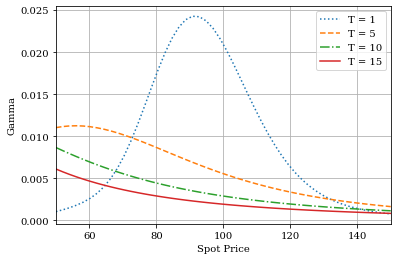

In [26]:
spot = np.linspace(50, 150)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in spot:
        temp = rsln_gmmbgamma_fst(i, G, time[j], r, sigma, A, Pi0, N, X)
        v.append(temp)
    plt.plot(spot, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Spot Price')
plt.xlim((50, 150))
plt.ylabel('Gamma')
plt.grid()

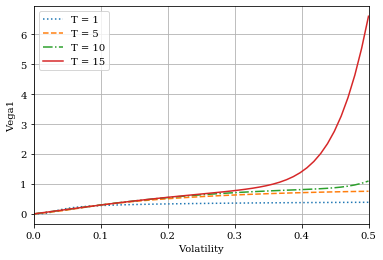

In [28]:
vol1 = np.linspace(0, 0.5)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in vol1:
        vol = [i, sigma[1]]
        temp = rsln_gmmbvega_fst(S0, G, time[j], r, vol, A, Pi0, N, X)[0]
        v.append(temp)
    plt.plot(vol1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Volatility')
plt.xlim((0, 0.5))
plt.ylabel('Vega1')
plt.grid()

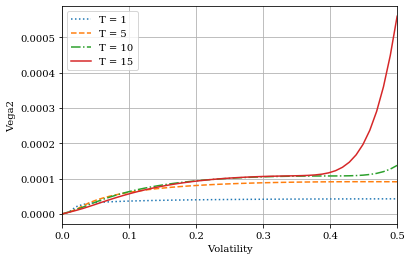

In [30]:
vol2 = np.linspace(0, 0.5)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in vol2:
        vol = [sigma[0], i]
        temp = rsln_gmmbvega_fst(S0, G, time[j], r, vol, A, Pi0, N, X)[1]
        v.append(temp)
    plt.plot(vol2, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Volatility')
plt.xlim((0, 0.5))
plt.ylabel('Vega2')
plt.grid()

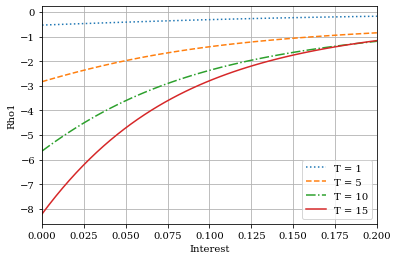

In [42]:
rho1 = np.linspace(0, 0.2)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in rho1:
        interest = [i, r[1]]
        temp = rsln_gmmbrho_fst(S0, G, time[j], interest, sigma, A, Pi0, N, X)[0]
        v.append(temp)
    plt.plot(rho1, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Interest')
plt.xlim((0, 0.2))
plt.ylabel('Rho1')
plt.grid()

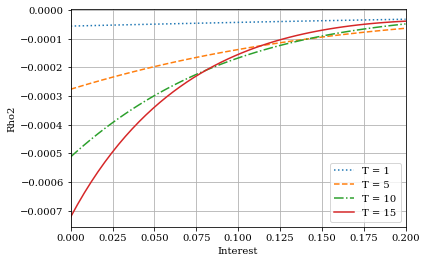

In [43]:
rho2 = np.linspace(0, 0.2)
time = [1, 5, 10, 15]
lab = ['T = 1', 'T = 5', 'T = 10', 'T = 15']
sty = [':', '--', '-.', '-']
for j in range(len(time)):
    v = []
    for i in rho2:
        interest = [r[0], i]
        temp = rsln_gmmbrho_fst(S0, G, time[j], interest, sigma, A, Pi0, N, X)[1]
        v.append(temp)
    plt.plot(rho2, v, label=lab[j], linestyle=sty[j])
plt.legend()
plt.xlabel('Interest')
plt.xlim((0, 0.2))
plt.ylabel('Rho2')
plt.grid()